<a href="https://colab.research.google.com/github/BertrandCoquard/fastbook/blob/master/Example_Multi_Label_Planet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Label Classification - Kaggle Amazon forest dataset
[dataset](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/notebooks?sortBy=relevance&group=everyone&search=fasta&page=1&pageSize=20&competitionId=6322)

Today we will be going over **multi-label** classification.


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

First let's install our libraries

In [2]:
# !pip install pandas==1.1.0
#Run once per session
# !pip install fastai --upgrade -q

NOTE: to prevent this error when upgrading fastai

ERROR: google-colab 1.0.0 has requirement pandas~=1.0.0; python_version >= "3.0", but you'll have pandas 1.1.1 which is incompatible.

In [3]:
import fastai; fastai.__version__

'2.7.10'

Now let's grab what we need. For this particular one, we want `vision` and `data`

In [4]:
from fastai.vision.all import *
from fastai.callback.fp16 import * # a callback call for mixed precision

For this multi-label problem, we will use **the Planet dataset**, where it's a collection of satellite images with multiple labels describing the scene. I'll go through and explain a few different ways to make this dataset, highlighting some of the flexibility the new `DataBlock` API can do. 

First, let's grab our data

In [5]:
planet_source = untar_data(URLs.PLANET_SAMPLE)

In [8]:
path=planet_source; path

Path('/root/.fastai/data/planet_sample')

NOTE: the path instruction gives us a relative path not an absoluted path.

In [9]:
df = pd.read_csv(path/'labels.csv')
df.head()

,image_name,tags
0,train_21983,partly_cloudy primary
1,train_9516,clear cultivation primary water
2,train_12664,haze primary
3,train_36960,clear primary
4,train_5302,haze primary road


NOTE: By looking at a few rows regarding our dataframe `df`, we have two columns: our images `image_name` (column 1) and the labels `tags` (column 2).  Multi-labels are stored in the tags column, and a blank space delimits them; i.e.: `partly_cloudy primary`

# Method 1 (DataBlock)

In [10]:
# the batch transformation
batch_tfms = aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [11]:
# the MultiCategory datablock
planet = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=ColReader(0, pref=f'{planet_source}/train/', suff='.jpg'),
                   splitter=RandomSplitter(),
                   get_y=ColReader(1, label_delim=' '),
                   item_tfms=[Resize(128)],
                   batch_tfms = batch_tfms)

* Multi-label so we want a `MultiCategoryBlock`
* `get_x` and `get_y` define how we expect to grab our data
* `RandomSplitter`: Create a function that splits `items` between train/val with `valid_pct` randomly. The default value is 20% of the data reserved for the validation set.
* `ColReader` works with Pandas `DataFrames`; in our dataframe, the column `tags` will be used to get the labels; the labels are separated by a blank space.


Now we can create dataloaders by passing in our source folder

In [12]:
# passing to the dataloader the pandas dataframe to get the image and labels.
dls = planet.dataloaders(df)

In [ ]:
# checking the categories
dls.c, dls.vocab

(17,
 ['agriculture', 'artisinal_mine', 'bare_ground', 'blooming', 'blow_down', 'clear', 'cloudy', 'conventional_mine', 'cultivation', 'habitation', 'haze', 'partly_cloudy', 'primary', 'road', 'selective_logging', 'slash_burn', 'water'])

NOTE: 
- `dls.c` indicates how many categories (classes) the model has.  We have 16 categories in total.  Knowing that one satellite image can have multiple categories.
- `dls.vocab` gives the categories names.

In [ ]:
# checking the one-hot encoding for one item
dls.dataset[8]

(PILImage mode=RGB size=256x256,
 TensorMultiCategory([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
                      0., 0.]))

NOTE: the one-hot encoding will put a `1` where that category is present for a given item.

>jargon: one-hot encoding: using a vector of 0s, whith a `1` in each location that is represented in the data, to encode a list of integers.

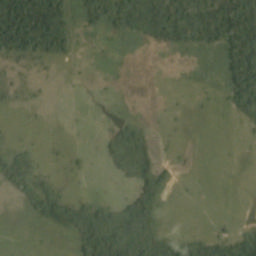

In [ ]:
dls.dataset[46][0]

In [ ]:
dls.dataset[8][1]

TensorMultiCategory([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
                     0., 0.])

In [ ]:
#@title Titre par défaut
# train shape
dls.train_ds[1][0].shape

(256, 256)

In [ ]:
print(len(dls.train_ds), len(dls.valid_ds))

800 200


In [ ]:
# checking the default batch size
dls.bs

64

In [ ]:
# checking the loss function
dls.loss_func

FlattenedLoss of BCEWithLogitsLoss()

NOTE: `BCEWithLogitsLoss` = One Sigmoid Layer + BCELoss (Binary CrossEntropy) (solved numerically unstable problem)

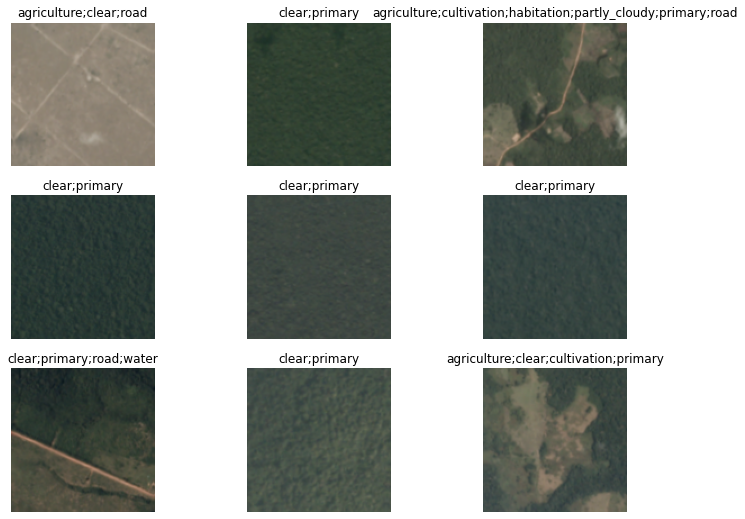

In [ ]:
# show the dataloader batch content
dls.show_batch(max_n=9, figsize=(12,9))

NOTE: Our data is now ready for training.

# Method 2: `Lambda`'s

for the pythonista!

This next version will instead use `lambda` functions to grab our image names, which get's rid of the `ColReader`, if you're more familiar with these

In [ ]:
blocks = (ImageBlock, MultiCategoryBlock)

First let's try our `get_x`. Our lambda function needs to return a `Path()` to our particular image. This can be done by including `f'{x[0]}.jpg'` 

But what is that even doing? Let's take a look

In [ ]:
get_x = lambda x:planet_source/'train'/f'{x[0]}.jpg'

If we pass in one row of our `DataFrame`, we should expect to see the entire path laid out in front of us!

In [ ]:
# checking one value from our dataframe df
val = df.values[0]; val

array(['train_21983', 'partly_cloudy primary'], dtype=object)

In [ ]:
# showing the results of get_x
get_x(df.values[0])

Path('/root/.fastai/data/planet_sample/train/train_21983.jpg')

Which it does! A nice, simple, and *clean* way to grab our paths. Let's see how our `y` getter will look like

In [ ]:
# getting the labels
get_y = lambda x:x[1].split(' ')

In [ ]:
# showing the results of get_y
get_y(df.values[0])

['partly_cloudy', 'primary']

Looks fairly close to the previous version, if you pay attention. Remember that our `x` is the `DataFrame`'s values, so if we grab position 1 from earlier, we can see that it's our labels!

Let's make our full `PipeLine` now that we're sure everything will work

In [ ]:
planet = DataBlock(blocks=blocks,
                   get_x=get_x,
                   splitter=RandomSplitter(),
                   get_y=get_y,
                   batch_tfms=batch_tfms)

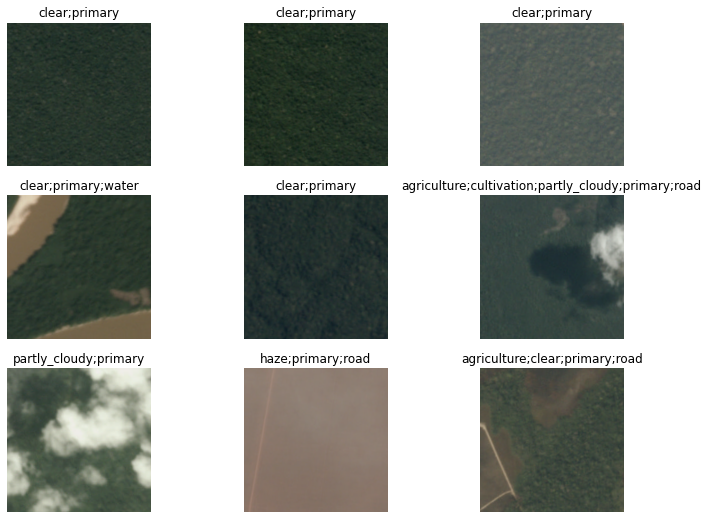

In [ ]:
dls = planet.dataloaders(df)
dls.show_batch(max_n=9, figsize=(12,9))

# Method 3: Custom `get_items` Functions

That previous one worked fine, but shouldn't I be able to do a one-liner? Since it's all right there instead of defining our `get_x` and `get_y`? There *IS*! We can create our own function, where we should expect to return both an `x` and a `y` value. Let's make one 

In [ ]:
# getting the images - getitems x, y
def _planet_items(x): return (
    f'{planet_source}/train/'+x.image_name+'.jpg', x.tags.str.split())

NOTE:  `x.tags.str.split() returns all the labels for a given image.

Our `DataBlock` now looks like so:

In [ ]:
planet = DataBlock.from_columns(blocks=(ImageBlock, MultiCategoryBlock),
                   get_items = _planet_items, 
                   splitter=RandomSplitter(),
                   batch_tfms=batch_tfms)

That's all our `DataBlock` needs if we can plan accordingly. Looks pretty clean!

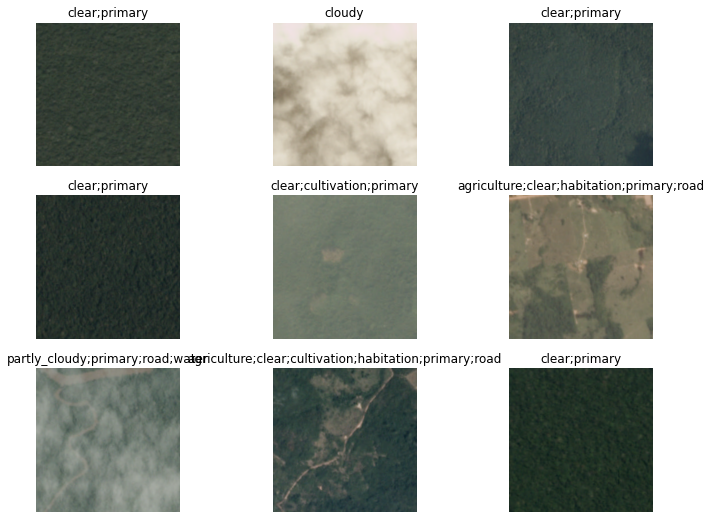

In [ ]:
dls = planet.dataloaders(df)
dls.show_batch(max_n=9, figsize=(12,9))

# Training a Model

We'll use a `resnet34` for this task

In [ ]:
learn = cnn_learner(dls, resnet34, pretrained=True, metrics=[accuracy_multi])

/usr/local/lib/python3.8/dist-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pt

  0%|          | 0.00/83.3M [00:00<?, ?B/s]

NOTE: `accuracy_multi` because we could have more than one prediction on a single image, we need to use the metric `accuracy_multi` and not `accuracy`. So, after applying the sigmoid to our activations (to make them between 0 and 1) we need to decide which ones are 0s and which ones are 1s by picking a threshold.  Each value above the threshold will be considered as a 1, and each value lower than the threshold will be considered a 0.

> Picking a theshold is important!  if you pick a threshold that is too low, you will often be failing to select correctly labeled objects. Here we are using the default threshold=0.5, you can try running the learner with a different threshold, i.e. 0.2.



```
learn = cnn_learner(dls, resnet34, pretrained=True, metrics=partial(accuracy_multi, thresh=0.2))
```



In [ ]:
??accuracy_multi

NOTE: the `cnn_learner` is a fastai object for the vision application.  Like any learner, it requires a dataloader `dls`, an architecture (also called a model) `resnet34` that has been trained on imagenet, and a list of metrics, here we are using only one metric `accuracy_multi`.

Model results are on a scale with a threshold instead of exact, allows for "it's not any" due to a sigmoid activation in the loss function

In [ ]:
class BCEWithLogitsLossFlat(BaseLoss):
    "Same as `nn.CrossEntropyLoss`, but flattens input and target."
    def __init__(self, *args, axis=-1, floatify=True, thresh=0.5, **kwargs):
        super().__init__(nn.BCEWithLogitsLoss, *args, axis=axis, floatify=floatify, is_2d=False, **kwargs)
        self.thresh = thresh

    def decodes(self, x):    return x>self.thresh
    def activation(self, x): return torch.sigmoid(x)

NOTE: `BCEWithLogitsLossFlat` operates as a sigmoid, in which, if any values which are > threshold (`thresh`), they are set as present. This goes back to nn.BCEWithLogitsLoss which is a pytorch function, and we see the sigmoid in the call to that function. This is not a fastai function. In summary, `BCEWithLogitsLossFlat` does both sigmoid and binary cross entropy in a single function.

Fastai has many loss functions and, of course you can add your own as well, here is the [link](https://docs.fast.ai/layers.html#fastai-loss-functions) to the loss functions readily available with fastai.

In [ ]:
# checking the learner loss function
learn.loss_func = BCEWithLogitsLossFlat()

NOTE: fastai automatically use this loss function for multiclassification.  It can be overidden by your own if needed.

We'll find a good learning rate

SuggestedLRs(valley=0.0020892962347716093)

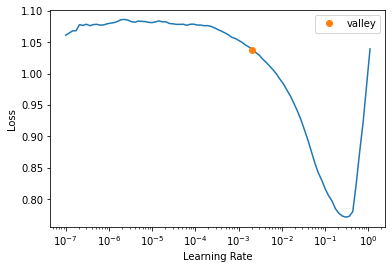

In [ ]:
# finding the best learning rate
learn.lr_find()

And train! (we'll also used mixed precision too!)

In [ ]:
# learning rate
lr = 1e-2
# using mixed precision
learn = learn.to_fp16()

NOTE: mixed precision is a technique referring to using less precise numbers (half precision floating point, also called `fp16` during training. NVIDIA GPU, since early 2020, supports a special feature called `tensor cores` that can dramatically speed up neural network training by 2-3x.  They also require a lot less GPU memory.  To enable this feature,just add `to_fp16()` after your learner creation.

In [ ]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.958399,0.674520,0.689118,00:03
1,0.741838,0.238210,0.929412,00:03
2,0.522352,0.154366,0.946176,00:03
3,0.397531,0.138190,0.950882,00:03
4,0.323153,0.136463,0.953235,00:03


Great! Let's save and `unfreeze` to train the rest of our model!

In [ ]:
learn.save('/content/models/stage-1')

Path('/content/models/stage-1.pth')

NOTE: `learn.save('stage-1')` will save the model file (extension `.pth` in the directory called `models`.  To load the model `learn.load('stage-1')`

SuggestedLRs(valley=0.0002754228771664202)

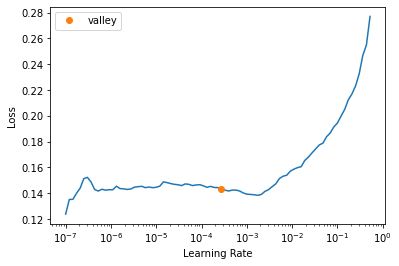

In [ ]:
learn.unfreeze()
learn.lr_find()

We can now go through and use a learning rate around 1e-5 or so, and then have an ending learning rate five times smaller than our starting

In [ ]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.147699,0.135867,0.950294,00:03
1,0.142664,0.125449,0.954118,00:03
2,0.133396,0.116218,0.953824,00:03
3,0.122572,0.116121,0.957059,00:03
4,0.115550,0.115463,0.957059,00:03


NOTE: `slice` is a Python object. The first value passed will be the learning rate in the earliest layer of the neural network and the second value will the learning rate in the final layer. The layers in between have a learning rates that are multiplicatively equidistant throughout that range.

NB: if using this example `lr_max=slice(1e-6, 1e-4)`it will set only the lowest layer of our net to a learning rate of `1e-6`; the other layers will scale up to `1e-4`.

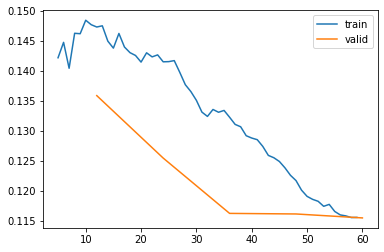

In [ ]:
learn.recorder.plot_loss()

NOTE:  if your validation loss improvement slows and get even worse, this is the point at which the model is starting to overfit.  Although it does not mean that your accuracy is getting worst.  Check the accuracy metrics, not the loss.  The loss is just a function we have given the computer to help us optimise our neural network.

NOTE: `show_results` shows the ground truth v.s. the predictions. Red titles means that the neural network prediction is not fully confident on that image satellite.

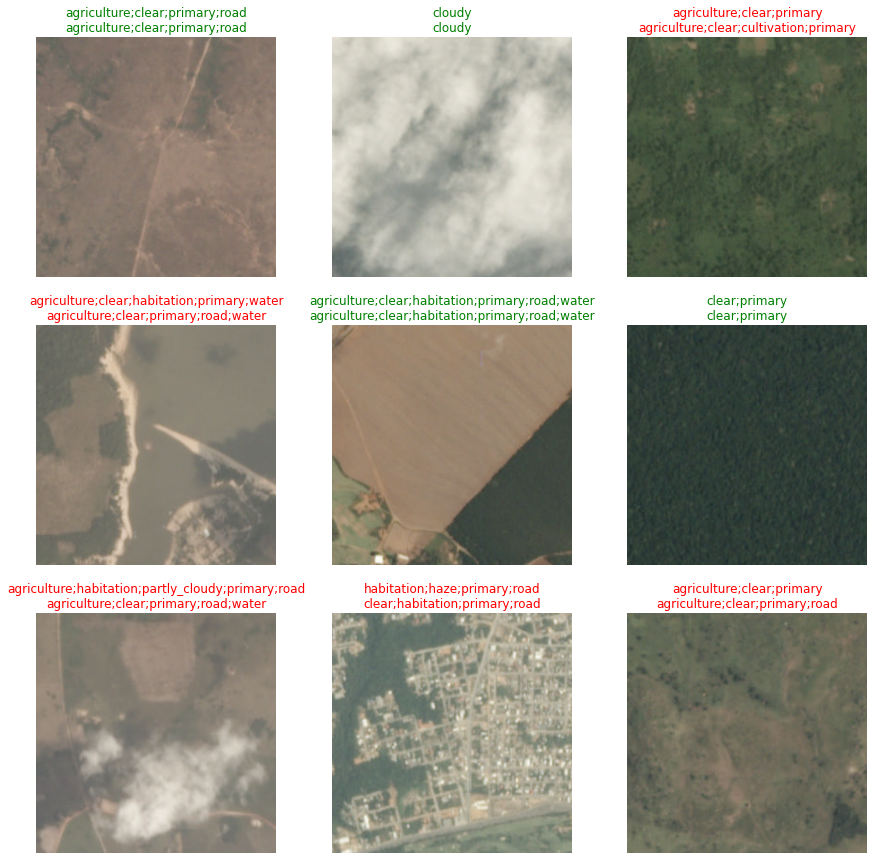

In [ ]:
learn.show_results(figsize=(15,15))

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

,target,predicted,probabilities,loss
0,agriculture;partly_cloudy;primary;road;slash_burn,agriculture;clear;cultivation;primary;road,"TensorBase([0.9883, 0.0016, 0.0510, 0.0018, 0.0010, 0.9923, 0.0017, 0.0021,\n 0.6700, 0.1071, 0.0100, 0.0214, 0.9946, 0.6328, 0.0046, 0.0150,\n 0.0228])",0.8647613525390625
1,agriculture;bare_ground;clear;habitation;primary;road;water,agriculture;clear;primary;water,"TensorBase([8.7343e-01, 1.5854e-03, 1.6166e-03, 1.6219e-04, 9.9153e-05,\n 9.9528e-01, 1.1235e-04, 2.0663e-04, 1.5140e-01, 3.8107e-02,\n 4.8406e-04, 3.6076e-03, 9.9975e-01, 5.9537e-02, 2.8462e-04,\n 3.3015e-04, 5.1403e-01])",0.7938914895057678
2,cloudy,clear;primary;water,"TensorBase([5.9866e-02, 5.5278e-04, 4.0617e-02, 7.7633e-04, 1.2113e-03,\n 8.9105e-01, 3.4834e-03, 8.6598e-04, 2.0668e-03, 8.5113e-03,\n 2.7684e-03, 3.7679e-02, 9.2192e-01, 3.5936e-03, 1.9717e-04,\n 8.3609e-04, 5.6644e-01])",0.6723551154136658
3,clear;primary;road;selective_logging,clear;primary,"TensorBase([1.4729e-02, 1.9043e-03, 3.2225e-03, 4.9437e-03, 5.3998e-04,\n 9.9059e-01, 5.3433e-03, 3.7264e-04, 2.4657e-02, 2.5213e-03,\n 4.2316e-03, 4.3994e-03, 9.9765e-01, 4.5033e-03, 3.6217e-03,\n 1.8173e-03, 3.2477e-03])",0.6534163355827332
4,agriculture;cultivation;habitation;haze;primary;road,agriculture;clear;primary;road,"TensorBase([9.6505e-01, 1.7265e-04, 6.1423e-04, 6.3619e-04, 2.8685e-04,\n 9.0698e-01, 5.1728e-04, 6.0471e-04, 5.5005e-02, 2.2074e-02,\n 1.6265e-01, 3.9301e-03, 9.9695e-01, 9.4261e-01, 2.4923e-04,\n 4.8218e-04, 3.3717e-02])",0.6498902440071106
5,habitation;haze;primary;road,clear;habitation;primary;road,"TensorBase([0.2723, 0.0126, 0.0194, 0.0061, 0.0073, 0.9919, 0.0031, 0.0113,\n 0.0211, 0.9959, 0.0117, 0.0119, 0.9086, 0.9945, 0.0060, 0.0026,\n 0.4524])",0.6114477515220642


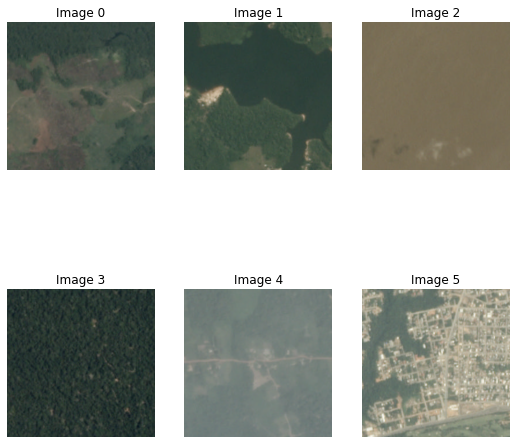

In [ ]:
interp.plot_top_losses(6, figsize=(9,9))